# Movie Ratings Capstome

#### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
# import prepare_stephen as ps
# import prepare_nick as pn
import wrangle as w
import datetime

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

import scipy.stats as stats
from math import sqrt

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Set default graph size
plt.rc('figure', figsize=(20.0, 10.0))
sns.set(rc = {'figure.figsize':(20,10)})


### Get Raw dirty data https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset?select=links.csv

In [2]:
df = w.wrangle_df()

clean.csv not detected.
Acquiring and Preparing Data
Using cached CSV
Clean CSV not detected.
Reading raw capstone.csv


In [3]:
df.shape

(6893, 23)

In [4]:
df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,runtime,imdb_id
id,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,False,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,False,1995-12-09,1995,98.0,tt0113101
6,Judgment Night,False,3.883820,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,10000000.0,12136938.0,2136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,False,1993-10-15,1993,110.0,tt0107286
11,Star Wars,True,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,True,1977-05-25,1977,121.0,tt0076759
12,Finding Nemo,True,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,True,2003-05-30,2003,100.0,tt0266543
13,Forrest Gump,True,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,True,1994-07-06,1994,142.0,tt0109830


# Prepare Data

> ### Get prepared data
> - Handle missing values (Drop / fill by mean|mode)
> - Encode categorical data
> - Columns content split required:
    - cast
    - crew
    - production_companies
    - production_countries
> - Rename columns to ease readability
> - Drop duplicates & unnecessary columns
> - Convert release_date column from object data type to datetime format and index date
> - Data scaling
> - Feature engineering
> - Split the data into train, validate, test

### Split cast and crew columns into first name last name and get only first 3 names

In [10]:
# df.loc[df['cast'].str.split().str.len() == 2, 'last_name'] = df['cast'].str.split().str[-1]
# df
# df = df.drop(columns = 'first_name')

#### Initial Data Check

### Final check for nulls 

In [5]:
df.isnull().any()

title                   False
success                 False
success_rating          False
genres                  False
cast_actor_1            False
cast_actor_2            False
cast_actor_3            False
total_n_cast            False
budget                  False
revenue                 False
profit_amount           False
vote_average            False
vote_count              False
production_companies    False
production_countries    False
overview                False
popularity              False
runtime                 False
profitable              False
release_date            False
release_year            False
runtime                 False
imdb_id                 False
dtype: bool

In [45]:
df['profit_amount'] = df.revenue - df.budget 

df['month'] = pd.DatetimeIndex(df['release_date']).month

df.head()

,title,success,success_rating,genres,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,budget,revenue,profit_amount,vote_average,vote_count,production_companies,production_countries,overview,popularity,runtime,profitable,release_date,release_year,runtime,imdb_id,month
id,,,,,,,,,,,,,,,,,,,,,,,,
5,Four Rooms,False,3.493750,Crime Comedy,Tim Roth,Antonio Banderas,Jennifer Beals,24.0,4000000.0,4300000.0,300000.0,6.5,539.0,MiramaxFilms ABandApart,UnitedStatesofAmerica,It's Ted the Bellhop's first night on the job....,9.026586,98.0,False,1995-12-09,1995,98.0,tt0113101,12
6,Judgment Night,False,3.883820,Action Thriller Crime,Emilio Estevez,Cuba Gooding Jr.,Denis Leary,15.0,10000000.0,12136938.0,2136938.0,6.4,79.0,UniversalPictures LargoEntertainment JVCEntert...,Japan UnitedStatesofAmerica,"While racing to a boxing match, Frank, Mike, J...",5.538671,110.0,False,1993-10-15,1993,110.0,tt0107286,10
11,Star Wars,True,285.487448,Adventure Action Science Fiction,Mark Hamill,Harrison Ford,Carrie Fisher,106.0,11000000.0,775398007.0,764398007.0,8.1,6778.0,Lucasfilm TwentiethCenturyFoxFilmCorporation,UnitedStatesofAmerica,Princess Leia is captured and held hostage by ...,42.149697,121.0,True,1977-05-25,1977,121.0,tt0076759,5
12,Finding Nemo,True,38.013564,Animation Family,Albert Brooks,Ellen DeGeneres,Alexander Gould,24.0,94000000.0,940335536.0,846335536.0,7.6,6292.0,PixarAnimationStudios,UnitedStatesofAmerica,"Nemo, an adventurous young clownfish, is unexp...",25.497794,100.0,True,2003-05-30,2003,100.0,tt0266543,5
13,Forrest Gump,True,50.537748,Comedy Drama Romance,Tom Hanks,Robin Wright,Gary Sinise,66.0,55000000.0,677945399.0,622945399.0,8.2,8147.0,ParamountPictures,UnitedStatesofAmerica,A man with a low IQ has accomplished great thi...,48.307194,142.0,True,1994-07-06,1994,142.0,tt0109830,7


> ### Split the data

In [7]:
# train, validate, test = ps.split_movies_data(df)

In [8]:
# print(f'DataFrame Shapes\n\tTrain {train.shape}, Validate: {validate.shape}, Test: {test.shape}')

# Explore Data

> ### Use train set

In [9]:
# train.hist(color = 'teal')
# plt.show()

> ### Visualizations

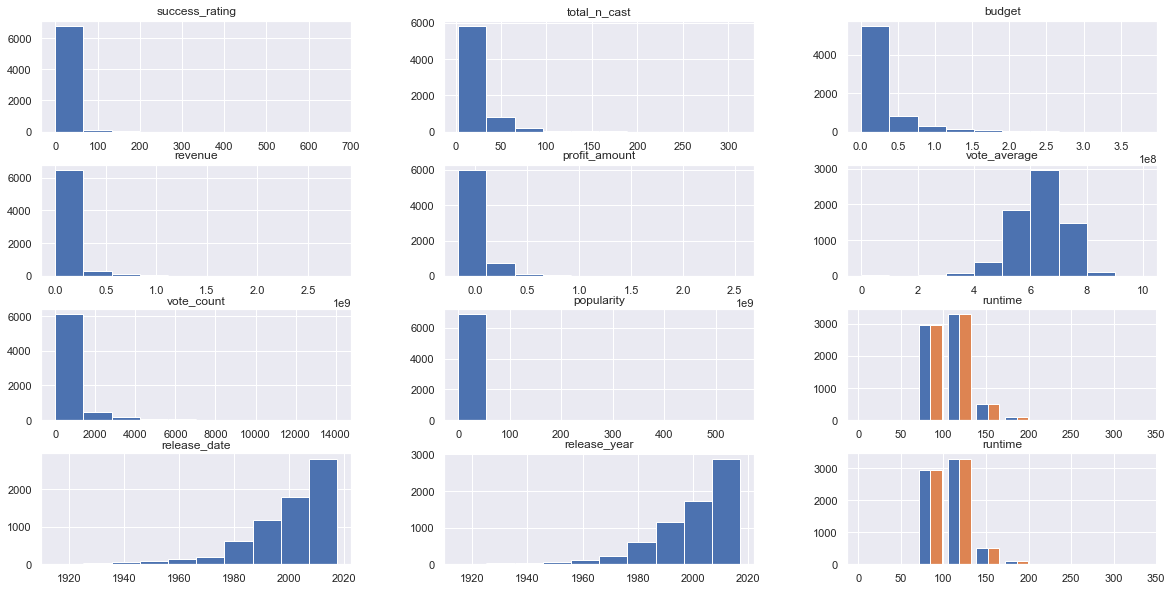

In [23]:
# Variable Distributions

df.hist()
plt.show()

### Correlation Heatmap

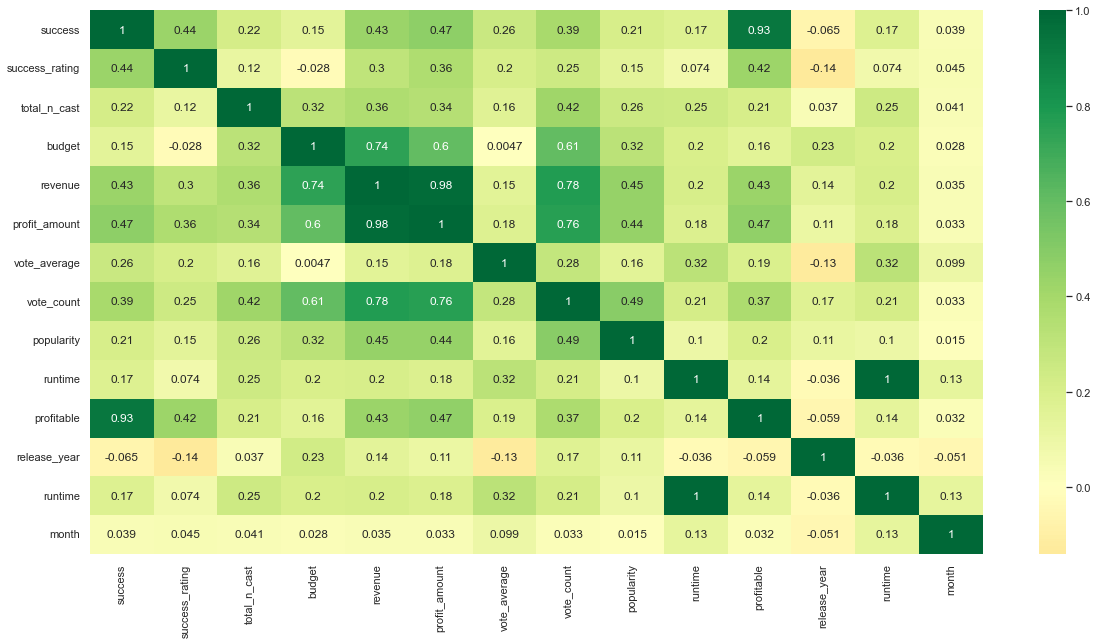

In [87]:
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, cmap='RdYlGn', center=0, annot=True)
None

### Success vs Non-success Distribution

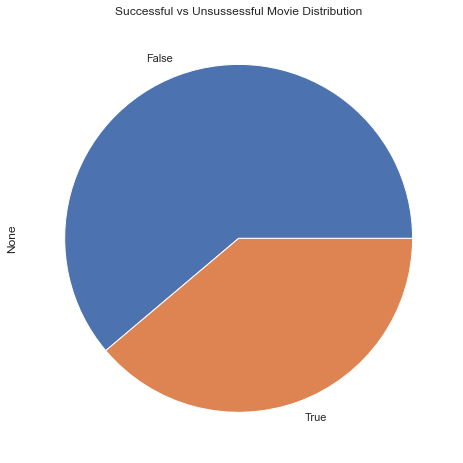

In [85]:
df1 = df.groupby(['success']).size()

df1.plot(kind='pie', subplots=True, figsize=(8, 8))
plt.title("Successful vs Unsussessful Movie Distribution")
plt.show()

In [86]:
### Movie success by month (from 1990 )

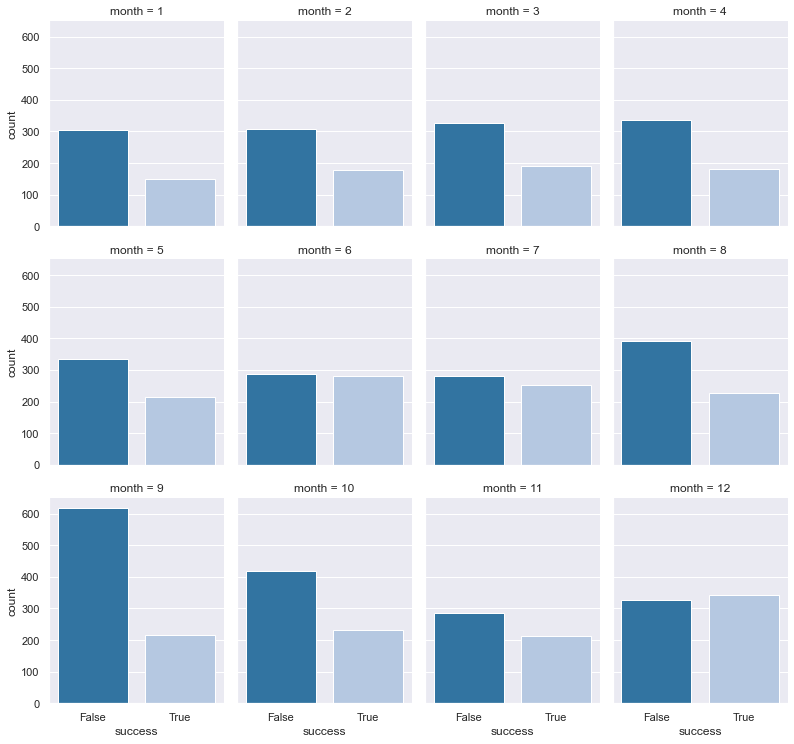

In [84]:
after_1990 = df[df.release_year >= 1990]

g = sns.catplot("success", col="month", col_wrap=4,
                data = after_1990,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')

plt.show()

### Movie Success After 1990 (by year)

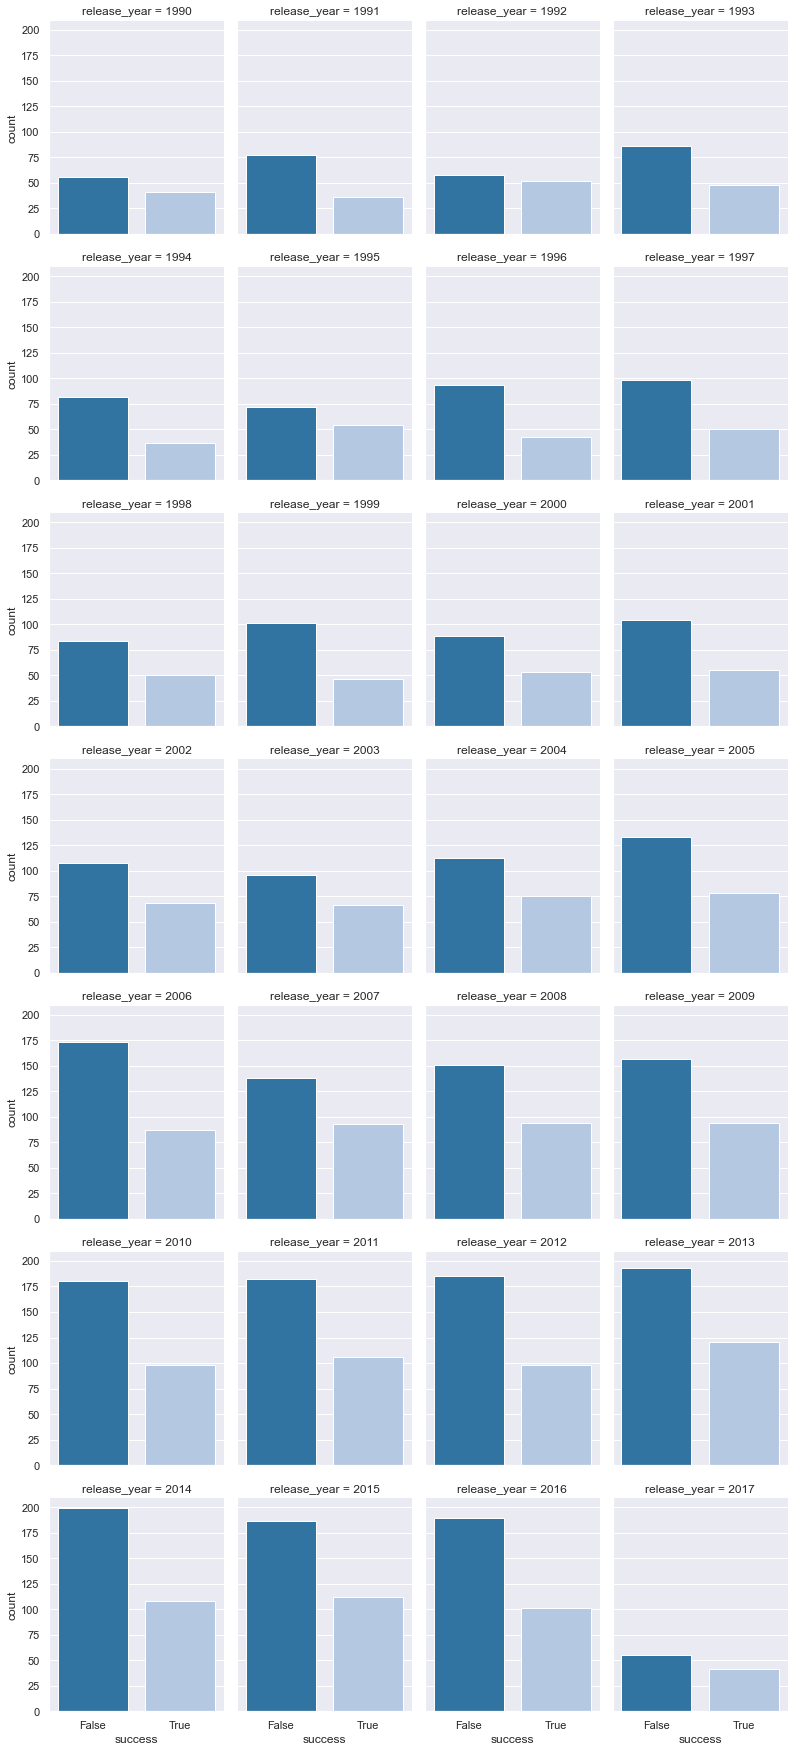

In [83]:
after_1990 = df[df.release_year >= 1990]

g = sns.catplot("success", col="release_year", col_wrap=4,
                data = after_1990,
                kind="count", height=3.5, aspect=.8, 
                palette='tab20')

plt.show()

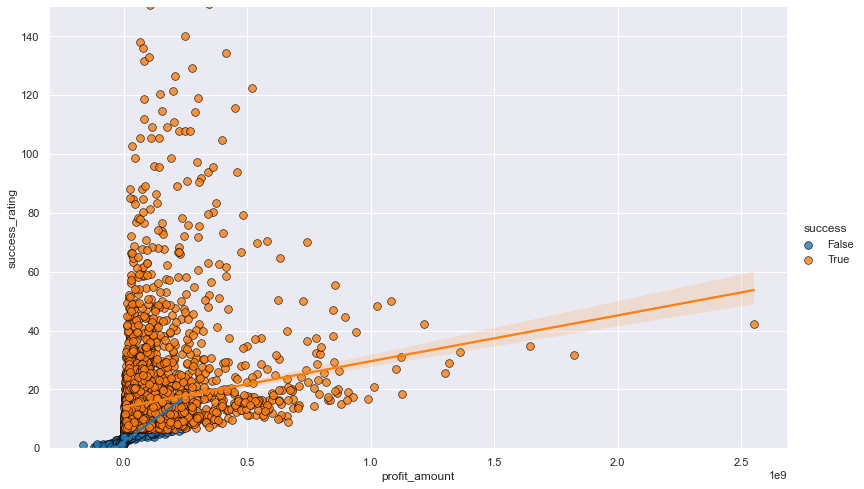

In [77]:
g = sns.lmplot(x="profit_amount", y="success_rating", hue="success", data=df, 
                     height=7, aspect=1.6, robust=True, palette='tab10', 
                     scatter_kws=dict(s=60, linewidths=.7, edgecolors='black'))
g.set(ylim=(0, 150))


> ### Univariate Exploration

> ### Bi-Variate Exploration

> ### Multi-Variate Exploration

> ### Hypothesis testing

In [11]:
# Set alpha value

alpha = 0.05

####  Is there a relationship between budget and revenue? 
 

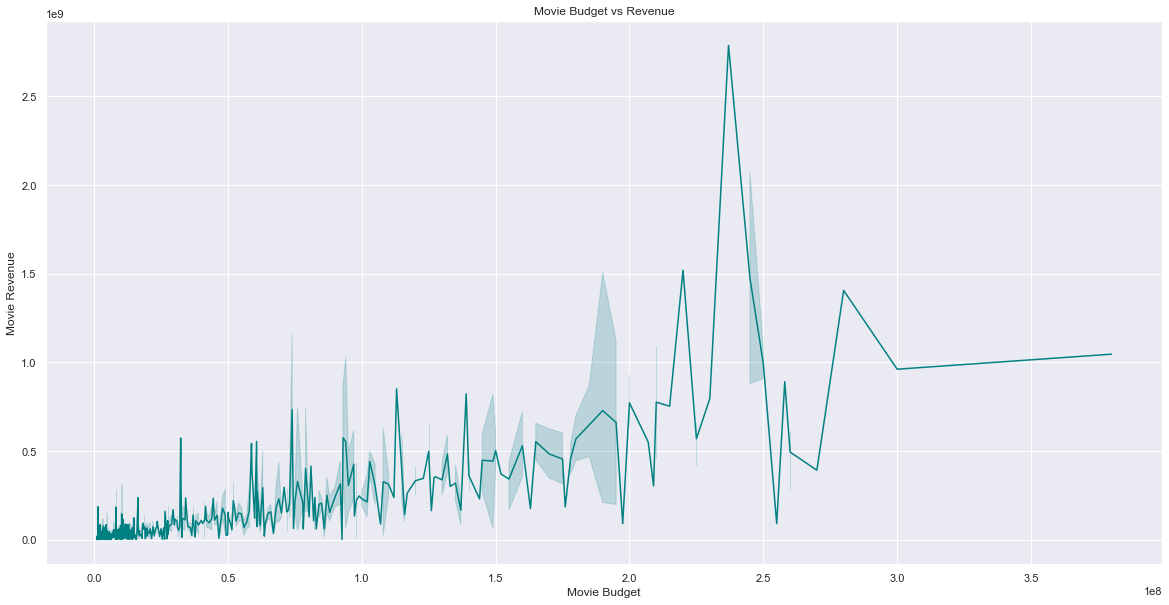

In [12]:
ax = sns.lineplot(x = df.budget, y = df.revenue, color = 'teal')
ax.set(xlabel = 'Movie Budget', ylabel = 'Movie Revenue')
ax.set(title = 'Movie Budget vs Revenue')
None

In [13]:
revenue = df.revenue.mean()
budget = df.budget.mean()

print(f'Mean Revenue: {revenue} \nMean Budget {budget}')
print('---------------------------------')
print(f'Mean Profit Difference {revenue - budget}')
print('---------------------------------')

Mean Revenue: 73568548.74307269 
Mean Budget 27120731.049035255
---------------------------------
Mean Profit Difference 46447817.69403744
---------------------------------


In [14]:
H0 = 'The is correlation between revenue and budgeting'
H1 = 'The is no correlation between revenue and budgeting'

x = df.budget
y = df.revenue

corr, p = stats.pearsonr(x, y)
corr, p

(0.7416271237680732, 0.0)

In [15]:
if (p < alpha):
    print(f'Reject --> {H0}')
else:
    print(f'Failed to Reject {H0}')

Reject --> The is correlation between revenue and budgeting


> NO CORRELATION BETWEEN REVENUE & BUDGET

#### How runtime affect movie success?



In [17]:
df.success_rating.head()

id
5       3.493750
6       3.883820
11    285.487448
12     38.013564
13     50.537748
Name: success_rating, dtype: float64

In [72]:
# sns.relplot(x = 'runtime', y = 'budget', data = df, kind = 'line',  ci="sd");
# None

In [29]:
train.columns

Index(['budget', 'genres', 'id', 'imdb_id', 'overview', 'popularity',
       'production_companies', 'production_countries', 'revenue', 'runtime',
       'title', 'vote_average', 'vote_count', 'cast_actor_1', 'cast_actor_2',
       'cast_actor_3', 'total_n_cast', 'release_year', 'profitable'],
      dtype='object')

#### What are the top 5 highest voted movies?


#### Which genre has the highest revenue? Or top 5


#### How does a production company affect revenue?

> ### Key exploration take-aways

In [36]:
import wrangle as w

In [37]:
df = w.wrangle_df()

CSV not detected.
reading other CSVs


In [38]:
df.shape

(7282, 19)

,budget,genres,id,imdb_id,overview,popularity,production_companies,production_countries,revenue,runtime,title,vote_average,vote_count,cast_actor_1,cast_actor_2,cast_actor_3,total_n_cast,release_year,profitable
release_date,,,,,,,,,,,,,,,,,,,
1915-02-08,8000000.00000,Drama History War,618,tt0004972,The Birth of A Nation is a silent film from 19...,5.11320,EpochFilmCo.,UnitedStatesofAmerica,11000000.00000,193.00000,The Birth of a Nation,6.40000,109.00000,Lillian Gish,Mae Marsh,Henry B. Walthall,49.00000,1915,False
1915-12-13,8000000.00000,Drama,70368,tt0005078,"A venal, spoiled stockbroker's wife impulsivel...",0.68041,JesseL.LaskyFeaturePlayCompany,UnitedStatesofAmerica,137365.00000,59.00000,The Cheat,4.80000,11.00000,Fannie Ward,Jack Dean,Sessue Hayakawa,11.00000,1915,False
1916-12-24,8000000.00000,Adventure Drama Action Science Fiction,30266,tt0006333,Captain Nemo has built a fantastic submarine f...,0.91778,TheUniversalFilmMfg.Co.,Bahamas UnitedStatesofAmerica,8000000.00000,105.00000,"20,000 Leagues Under the Sea",6.00000,7.00000,Lois Alexander,Curtis Benton,Wallace Clarke,13.00000,1916,False
1918-08-01,8000000.00000,Comedy Drama,54242,tt0009369,"Mickey, an orphan who has been brought up in a...",0.21101,MabelNormandFeatureFilmCompany,UnitedStatesofAmerica,8000000.00000,93.00000,Mickey,7.50000,4.00000,Mabel Normand,George Nichols,Wheeler Oakman,8.00000,1918,False
1921-01-21,8000000.00000,Comedy Drama,10098,tt0012349,Considered one of Charlie Chaplin's best films...,8.16846,CharlesChaplinProductions FirstNationalPictures,UnitedStatesofAmerica,2500000.00000,68.00000,The Kid,8.00000,404.00000,Charlie Chaplin,Jackie Coogan,Edna Purviance,35.00000,1921,False


# Modeling

### Test Model

## Conclusion & Recommendations